## Electrode Mapping

This notebook performs a comprehensive analysis of intracranial electrode data by mapping neural dynamics to anatomical brain regions using two complementary approaches:

1. **LDS Line Attractor Analysis:**  
   - Fits linear dynamical systems (LDS) to neural time series for each subject and condition (rest, music, speech).
   - Calculates line attractor scores from the eigenvalues of the LDS dynamics matrix, identifying regions capable of maintaining persistent neural states.
   - Maps electrodes to brain regions using FreeSurfer atlas and summarizes line attractor scores by region and condition.

2. **Causal Driver Analysis:**  
   - Identifies electrodes with high embedding variance using empirical dynamical modeling (EDM), marking them as causal hubs that drive network-wide neural dynamics.
   - Maps these causal driver electrodes to brain regions and summarizes causal strength by region and condition.

3. **Comparison and Correlation:**  
   - Compares the overlap between regions identified by LDS and causal driver analyses.
   - Performs correlation analysis to assess the relationship between LDS line attractor scores and causal driver variances across regions and conditions.
   - Visualizes results and provides a summary table of key findings, highlighting condition-dependent relationships.

The notebook includes detailed visualizations, interpretation of results, and a summary of statistical findings, demonstrating that the coupling between LDS and causal driver metrics is strongest during rest and weaker during music

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py
from pathlib import Path
from collections import defaultdict, Counter
import mne
import ssm
from sklearn.decomposition import PCA
import autograd.numpy.random as npr
from joblib import Parallel, delayed, Memory
import multiprocessing as mp
import gc
import psutil
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [6]:
# Set up plotting style 
sns.set_style("white")
sns.set_context("talk")
npr.seed(0)

### DATA LOADING 

In [7]:
condition_paths = {
    "rest": (
        Path("/home/sadel/data/seeg_rest_ispeech"),
        "*_rest-epo.fif"
    ),
    "music": (
        Path("/home/sadel/data/seeg_music_reflejos_ispeech"),
        "*_music-epo.fif"
    ),
    "speech": (
        Path("/home/sadel/data/seeg_speech/data/BIDS/electrophy_fif"),
        "*_adjusted-epo.fif"
    ),
}

In [8]:
# LOAD LDS RESULTS FROM SAVED FILE
import pickle

print("Loading LDS results from stored file...")

try:
    with open('/home/sadel/data/lds_brain_mapping.pkl', 'rb') as f:
        lds_brain_mapping_loaded = pickle.load(f)
    
    print(f"Loaded LDS data for {len(lds_brain_mapping_loaded)} subjects")
    
    # Convert to the format expected by your brain mapping code
    lds_results = {}
    for subject_id, conditions in lds_brain_mapping_loaded.items():
        lds_results[subject_id] = {}
        for condition, data in conditions.items():
            lds_results[subject_id][condition] = {
                'A': np.array(data['A_matrix']),
                'b': np.array(data['b_vector']),
                'tau': data['tau'],
                'line_score': data['line_score'],
                'eigenvals': np.array(data['eigenvals']),
                'states': None,  # Not needed for brain mapping
                'channel_names': []  # Will be populated from electrode mapping
            }
    
    print("LDS results loaded and ready for brain mapping!")
    
    # Show summary of loaded data
    print(f"\nLoaded LDS data summary:")
    for condition in ['rest', 'music', 'speech']:
        n_subjects = sum(1 for subj_data in lds_results.values() if condition in subj_data)
        print(f"- {condition.upper()}: {n_subjects} subjects")
    
except FileNotFoundError:
    print("ERROR: LDS results file not found. Please run ldsAnalyzeFinal.ipynb first.")
    lds_results = {}

Loading LDS results from stored file...
Loaded LDS data for 24 subjects
LDS results loaded and ready for brain mapping!

Loaded LDS data summary:
- REST: 24 subjects
- MUSIC: 24 subjects
- SPEECH: 24 subjects


In [9]:
# LOAD CAUSAL DRIVERS RESULTS FROM SAVED FILE
print("Loading causal drivers results from stored file...")

try:
    with open('/home/sadel/data/causal_drivers_mapping.pkl', 'rb') as f:
        causal_drivers_brain_mapping_loaded = pickle.load(f)
        
    print(f"Loaded causal drivers data for {len(causal_drivers_brain_mapping_loaded)} subjects")
    
    # NO MORE MOCK RECONSTRUCTION - USE ACTUAL STORED DATA DIRECTLY!
    print("Using stored high-variance electrodes directly (no reconstruction needed)")
    
    print("Causal drivers results loaded and ready for brain mapping!")
    
    # Show summary of loaded data
    print(f"\nLoaded causal drivers data summary:")
    for condition in ['rest', 'music', 'speech']:
        n_subjects = sum(1 for subj_data in causal_drivers_brain_mapping_loaded.values() if condition in subj_data)
        print(f"- {condition.upper()}: {n_subjects} subjects")

    
except FileNotFoundError: 
    print("ERROR: Causal drivers results file not found. Please run casualDrivers.ipynb first.")
    causal_drivers_brain_mapping_loaded = {}

Loading causal drivers results from stored file...
Loaded causal drivers data for 24 subjects
Using stored high-variance electrodes directly (no reconstruction needed)
Causal drivers results loaded and ready for brain mapping!

Loaded causal drivers data summary:
- REST: 24 subjects
- MUSIC: 24 subjects
- SPEECH: 24 subjects


## Mapping 

In [10]:
def load_electrode_mapping(subject_id):
    """Load electrode to brain region mapping using FreeSurfer, always assign the most probable valid region"""
    possible_paths = [
        Path(f"/home/sadel/data/seeg_speech/data/BIDS/freesurfer/{subject_id}/elec2atlas.mat"),
        Path(f"/home/sadel/data/seeg_rest_ispeech/freesurfer/{subject_id}/elec2atlas.mat"),
        Path(f"/home/sadel/data/seeg_music_reflejos_ispeech/freesurfer/{subject_id}/elec2atlas.mat"),
        Path(f"/home/sadel/data/freesurfer/{subject_id}/elec2atlas.mat"),
        Path(f"/home/sadel/data/{subject_id}/elec2atlas.mat"),
    ]
    freesurfer_path = None
    for path in possible_paths:
        if path.exists():
            freesurfer_path = path
            print(f"Found mapping for {subject_id} at: {freesurfer_path}")
            break
    if freesurfer_path is None:
        print(f"No electrode mapping found for {subject_id}")
        return None, None
    try:
        with h5py.File(freesurfer_path, 'r') as f:
            atlas = 'Destrieux'
            labels_ds = f[atlas]['label']
            probs_ds = f[atlas]['prob']
            n_regions, n_electrodes = probs_ds.shape
            region_labels_all = [f[labels_ds[0, i]][:].astype(np.uint8).tobytes().decode('utf-8') for i in range(labels_ds.shape[1])]
            final_labels = []
            final_probs = []
            def is_invalid_label(label):
                if label is None: return True
                label_l = label.lower()
                return (label_l.strip() == '' or
                        'unknown' in label_l or
                        'medial.wall' in label_l or
                        'no label found' in label_l or
                        'no_label_found' in label_l or
                        len(label_l) <= 2)
            for elec_idx in range(n_electrodes):
                region_probs = probs_ds[:, elec_idx]
                region_labels = [f[labels_ds[0, i]][:].astype(np.uint8).tobytes().decode('utf-8') for i in range(labels_ds.shape[1])]
                sorted_indices = np.argsort(region_probs)[::-1]
                chosen_label = None
                chosen_prob = 0.0
                for idx in sorted_indices:
                    candidate_label = region_labels[idx]
                    candidate_prob = region_probs[idx]
                    if not is_invalid_label(candidate_label):
                        chosen_label = candidate_label
                        chosen_prob = candidate_prob
                        break
                if chosen_label is None:
                    # If all labels are invalid, just take the top label regardless
                    idx = sorted_indices[0]
                    chosen_label = region_labels[idx]
                    chosen_prob = region_probs[idx]
                final_labels.append(chosen_label)
                final_probs.append(chosen_prob)
            print(f"Loaded mapping for {subject_id}: {len(final_labels)} electrodes mapped.")
            return final_labels, final_probs
    except Exception as e:
        print(f"Error loading electrode mapping for {subject_id}: {e}")
        return None, None

#### Map causal drivers using direct index mapping

##### CAUSAL DRIVERS ANALYSIS TO BRAIN ATLAS MAPPING - HIGH VARIANCE METHODOLOGY

CAUSAL DRIVERS DETECTION IN ETD ANALYSIS:
The causal drivers analysis identifies brain regions with high-variance embeddings
that act as "causal hubs" driving network-wide neural dynamics
Based on empirical dynamical modeling (EDM) and time-delay embedding variance

1. MATHEMATICAL FOUNDATION:
---------------------------
Empirical Dynamical Modeling: X(t) = [x(t), x(t-τ), x(t-2τ), ..., x(t-(E-1)τ)]
Time-delay embedding reconstructs attractor from single time series
High variance in embedding space indicates strong causal influence on network
- High embedding variance → Causal driver (controls network dynamics)
- Low embedding variance → Driven node (follows network dynamics)
- Convergent Cross-Mapping tests directional causality between channels

In [ ]:

print("\nMapping stored causal drivers to brain regions (direct index approach)...")
causal_brain_mapping = {}

for subject_id, conditions in causal_drivers_brain_mapping_loaded.items():
    labels, probs = load_electrode_mapping(subject_id)
    
    if labels is None:
        print(f"Skipping {subject_id} - no electrode mapping available")
        continue
    causal_brain_mapping[subject_id] = {}
    
    for condition, data in conditions.items():
        causal_drivers_list = data.get('causal_drivers', [])
        print(f"  {subject_id}-{condition}: Found {len(causal_drivers_list)} stored causal drivers")
        
        high_var_regions = []
        skipped_count = 0
        
        for driver_info in causal_drivers_list:
            idx = driver_info.get('channel_index', None)
            electrode_name = driver_info.get('channel_name', None)
            embedding_var = driver_info.get('embedding_variance', None)
            causal_rank = driver_info.get('causal_rank', None)
            
            if idx is not None and idx < len(labels) and idx < len(probs) and labels[idx] is not None:
                region = labels[idx]
                prob = probs[idx]
                
                if (region and 
                    region.strip() != '' and 
                    'unknown' not in region.lower() and
                    prob > 0.01):
                    high_var_regions.append({
                        'electrode': electrode_name,
                        'region': region,
                        'probability': prob,
                        'index': idx,
                        'embedding_variance': embedding_var,
                        'causal_rank': causal_rank
                    })
                    print(f"      -> {electrode_name} (idx {idx}) -> {region} (prob: {prob:.3f}, var: {embedding_var:.4f}, rank: {causal_rank})")
                else:
                    print(f"      -> {electrode_name} (idx {idx}) -> Invalid region: {region}")
                    skipped_count += 1
            else:
                print(f"      -> {electrode_name} (idx {idx}) -> Index out of range or no mapping")
                skipped_count += 1
        
        causal_brain_mapping[subject_id][condition] = {
            'high_variance_electrodes': high_var_regions,
            'total_electrodes': len(data.get('all_channel_names', [])),
            'skipped_electrodes': skipped_count
        }
        
        print(f"  {subject_id}-{condition}: Successfully mapped {len(high_var_regions)} electrodes ({skipped_count} skipped)")

print(f"\nCompleted causal drivers brain mapping for {len(causal_brain_mapping)} subjects")

# Verify we got results
total_mapped = sum(len(conditions[condition]['high_variance_electrodes']) 
                  for conditions in causal_brain_mapping.values() 
                  for condition in conditions)
print(f"Total causal driver electrodes mapped to brain regions: {total_mapped}")


Mapping stored causal drivers to brain regions (direct index approach)...
Found mapping for sub-001 at: /home/sadel/data/seeg_speech/data/BIDS/freesurfer/sub-001/elec2atlas.mat
Loaded mapping for sub-001: 173 electrodes mapped.
  sub-001-rest: Found 1 stored causal drivers
      -> CP'13 (idx 131) -> Left-Hippocampus (prob: 100.000, var: 0.0000, rank: 1)
  sub-001-rest: Successfully mapped 1 electrodes (0 skipped)
  sub-001-music: Found 1 stored causal drivers
      -> CP'13 (idx 131) -> Left-Hippocampus (prob: 100.000, var: 0.0000, rank: 1)
  sub-001-music: Successfully mapped 1 electrodes (0 skipped)
  sub-001-speech: Found 1 stored causal drivers
      -> CP'13 (idx 131) -> Left-Hippocampus (prob: 100.000, var: 0.0000, rank: 1)
  sub-001-speech: Successfully mapped 1 electrodes (0 skipped)
Found mapping for sub-002 at: /home/sadel/data/seeg_speech/data/BIDS/freesurfer/sub-002/elec2atlas.mat
Loaded mapping for sub-001: 173 electrodes mapped.
  sub-001-rest: Found 1 stored causal dri

#### Map LDS results to brain regions

##### LDS ANALYSIS TO BRAIN ATLAS MAPPING - LINE ATTRACTOR SCORING METHODOLOGY


LINE ATTRACTOR DETECTION IN LDS ANALYSIS:

The line attractor scoring identifies brain regions with line-like neural dynamics
Based on eigenvalue analysis of the dynamics matrix A from LDS fitting

1. MATHEMATICAL FOUNDATION:
---------------------------
Linear Dynamical System: x(t+1) = A*x(t) + b + noise
Eigenvalue decomposition of A reveals attractor geometry:
- 2 negative real eigenvalues → Point attractor (converges to fixed point)
- 1 near-zero, 1 negative → Line attractor (neutral + stable dimensions)
- Complex eigenvalues → Oscillatory dynamics
- Positive eigenvalues → Unstable dynamics

In [12]:


print("\nMapping LDS results to brain regions...")
lds_brain_mapping = {}

for subject_id, conditions in lds_results.items():
    labels, probs = load_electrode_mapping(subject_id)
    
    if labels is None:
        print(f"Skipping {subject_id} - no electrode mapping available")
        continue
        
    lds_brain_mapping[subject_id] = {}
    
    for condition, result in conditions.items():
        line_score = result['line_score']
        tau = result['tau']
        
        # Map electrodes with valid brain regions (improved coverage with probabilistic fallback)
        electrode_brain_mapping = []
        for i, (label, prob) in enumerate(zip(labels, probs)):
            if label is not None:  # Now only None if truly no region found
                electrode_brain_mapping.append({
                    'electrode': f'elec_{i}',  # Generic electrode name
                    'region': label,
                    'probability': prob,
                    'line_score': line_score,
                    'tau': tau,
                    'index': i
                })
        
        lds_brain_mapping[subject_id][condition] = {
            'electrodes': electrode_brain_mapping,
            'line_score': line_score,
            'tau': tau
        }
        
        print(f"  {subject_id}-{condition}: Mapped {len(electrode_brain_mapping)} valid electrodes to brain regions")

print(f"\nCompleted LDS brain mapping for {len(lds_brain_mapping)} subjects")


Mapping LDS results to brain regions...
Found mapping for sub-001 at: /home/sadel/data/seeg_speech/data/BIDS/freesurfer/sub-001/elec2atlas.mat
Loaded mapping for sub-001: 173 electrodes mapped.
  sub-001-rest: Mapped 173 valid electrodes to brain regions
  sub-001-music: Mapped 173 valid electrodes to brain regions
  sub-001-speech: Mapped 173 valid electrodes to brain regions
Found mapping for sub-002 at: /home/sadel/data/seeg_speech/data/BIDS/freesurfer/sub-002/elec2atlas.mat
Loaded mapping for sub-002: 198 electrodes mapped.
  sub-002-rest: Mapped 198 valid electrodes to brain regions
  sub-002-music: Mapped 198 valid electrodes to brain regions
  sub-002-speech: Mapped 198 valid electrodes to brain regions
Found mapping for sub-003 at: /home/sadel/data/seeg_speech/data/BIDS/freesurfer/sub-003/elec2atlas.mat
Loaded mapping for sub-003: 211 electrodes mapped.
  sub-003-rest: Mapped 211 valid electrodes to brain regions
  sub-003-music: Mapped 211 valid electrodes to brain regions
  

### Analysis 

In [13]:
# Analyze LDS line attractor patterns by brain region 
region_line_scores = defaultdict(list)
region_counts = Counter()

# Helper to check if a label is valid
def is_valid_region(region):
    if region is None: return False
    region_l = region.lower()
    return (region_l.strip() != '' and
            'unknown' not in region_l and
            'medial.wall' not in region_l and
            'no label found' not in region_l and
            len(region_l) > 2)

for subject_id, conditions in lds_brain_mapping.items():
    for condition, data in conditions.items():
        line_score = data['line_score']

        if not np.isnan(line_score):
            for electrode_info in data['electrodes']:
                region = electrode_info['region']
                if is_valid_region(region):
                    region_line_scores[region].append({
                        'subject': subject_id,
                        'condition': condition,
                        'line_score': line_score,
                        'tau': data['tau'],
                        'electrode': electrode_info['electrode'],
                        'probability': electrode_info['probability']
                    })
                    region_counts[region] += 1
 
print(f"Found line attractor data for {len(region_counts)} brain regions")

Found line attractor data for 11 brain regions


In [14]:
# Analyze causal drivers patterns by brain region
causal_region_stats = defaultdict(list)
causal_region_counts = Counter()

# Helper to check if a label is valid
def is_valid_region(region):
    if region is None: return False
    region_l = region.lower()
    return (region_l.strip() != '' and
            'unknown' not in region_l and
            'medial.wall' not in region_l and
            'no label found' not in region_l and
            len(region_l) > 2)

for subject_id, conditions in causal_brain_mapping.items():
    for condition, data in conditions.items():
        high_var_electrodes = data.get('high_variance_electrodes', [])

        for electrode_info in high_var_electrodes:
            region = electrode_info['region']
            if is_valid_region(region):
                causal_region_stats[region].append({
                    'subject': subject_id,
                    'condition': condition,
                    'embedding_variance': electrode_info['embedding_variance'],
                    'probability': electrode_info['probability'],
                    'electrode': electrode_info['electrode']
                })
                causal_region_counts[region] += 1

print(f"Found causal drivers data for {len(causal_region_counts)} brain regions")

Found causal drivers data for 11 brain regions


### Visualizations

In [15]:
def plot_line_scores_by_region(region_line_scores, region_counts, top_n=12):
    """Plot line attractor scores by brain region"""
    def is_valid_region(region):
        if region is None: return False
        region_l = region.lower()
        return (region_l.strip() != '' and
                'unknown' not in region_l and
                'medial.wall' not in region_l and
                'no label found' not in region_l and
                len(region_l) > 2)
    if len(region_counts) == 0:
        print("No line attractor data available for plotting.")
        return pd.DataFrame()
    top_regions = [region for region, count in region_counts.most_common(top_n) if is_valid_region(region)]
    plot_data = []
    for region in top_regions:
        if region in region_line_scores and is_valid_region(region):
            for entry in region_line_scores[region]:
                if not np.isnan(entry['line_score']):
                    clean_region = region.replace('ctx_', '').replace('_', ' ').title()
                    plot_data.append({
                        'region': clean_region,
                        'line_score': entry['line_score'],
                        'condition': entry['condition'],
                        'subject': entry['subject'],
                        'tau': entry['tau'],
                        'probability': entry['probability'],
                        'electrode': entry.get('electrode', 'Unknown')
                    })
    if plot_data:
        df_plot = pd.DataFrame(plot_data)
        plt.figure(figsize=(20, 15))
        plt.subplot(3, 1, 1)
        sns.boxplot(data=df_plot, x='region', y='line_score')
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Line Attractor Scores by Brain Region')
        plt.ylabel('Line Score (lower = more line-like)')
        plt.yscale('log')
        plt.subplot(3, 1, 2)
        sns.boxplot(data=df_plot, x='region', y='line_score', hue='condition')
        plt.xticks(rotation=45, ha='right')
        plt.title('Line Attractor Scores by Region and Condition')
        plt.ylabel('Line Score (lower = more line-like)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.yscale('log')
        plt.subplot(3, 1, 3)
        sns.boxplot(data=df_plot, x='region', y='tau')
        plt.xticks(rotation=45, ha='right')
        plt.title('Timescales (Tau) by Brain Region')
        plt.ylabel('Tau (time constant)')
        plt.tight_layout()
        plt.show()
        return df_plot
    else:
        print("No valid line attractor data for plotting.")
        return pd.DataFrame()

In [16]:
def plot_causal_drivers_by_region(causal_region_stats, causal_region_counts, top_n=12):
    """Plot causal drivers by brain region"""
    def is_valid_region(region):
        if region is None: return False
        region_l = region.lower()
        return (region_l.strip() != '' and
                'unknown' not in region_l and
                'medial.wall' not in region_l and
                'no label found' not in region_l and
                len(region_l) > 2)
    if len(causal_region_counts) == 0:
        print("No causal drivers data available for plotting.")
        return pd.DataFrame()
    top_regions = [region for region, count in causal_region_counts.most_common(top_n) if is_valid_region(region)]
    plot_data = []
    for region in top_regions:
        if region in causal_region_stats and is_valid_region(region):
            for entry in causal_region_stats[region]:
                clean_region = region.replace('ctx_', '').replace('_', ' ').title()
                plot_data.append({
                    'region': clean_region,
                    'embedding_variance': entry['embedding_variance'],
                    'condition': entry['condition'],
                    'subject': entry['subject'],
                    'electrode': entry.get('electrode', 'Unknown')
                })
    if plot_data:
        df_plot = pd.DataFrame(plot_data)
        plt.figure(figsize=(22, 16))
        plt.subplot(2, 1, 1)
        sns.boxplot(data=df_plot, x='region', y='embedding_variance')
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Causal Driver Strength by Brain Region')
        plt.ylabel('Embedding Variance (causal strength)')
        plt.subplot(2, 1, 2)
        sns.boxplot(data=df_plot, x='region', y='embedding_variance', hue='condition')
        plt.xticks(rotation=45, ha='right')
        plt.title('Causal Driver Strength by Brain Region and Condition')
        plt.ylabel('Embedding Variance (causal strength)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        return df_plot
    else:
        print("No causal drivers data available for plotting.")
        return pd.DataFrame()

### Results


LDS LINE ATTRACTOR VISUALIZATION


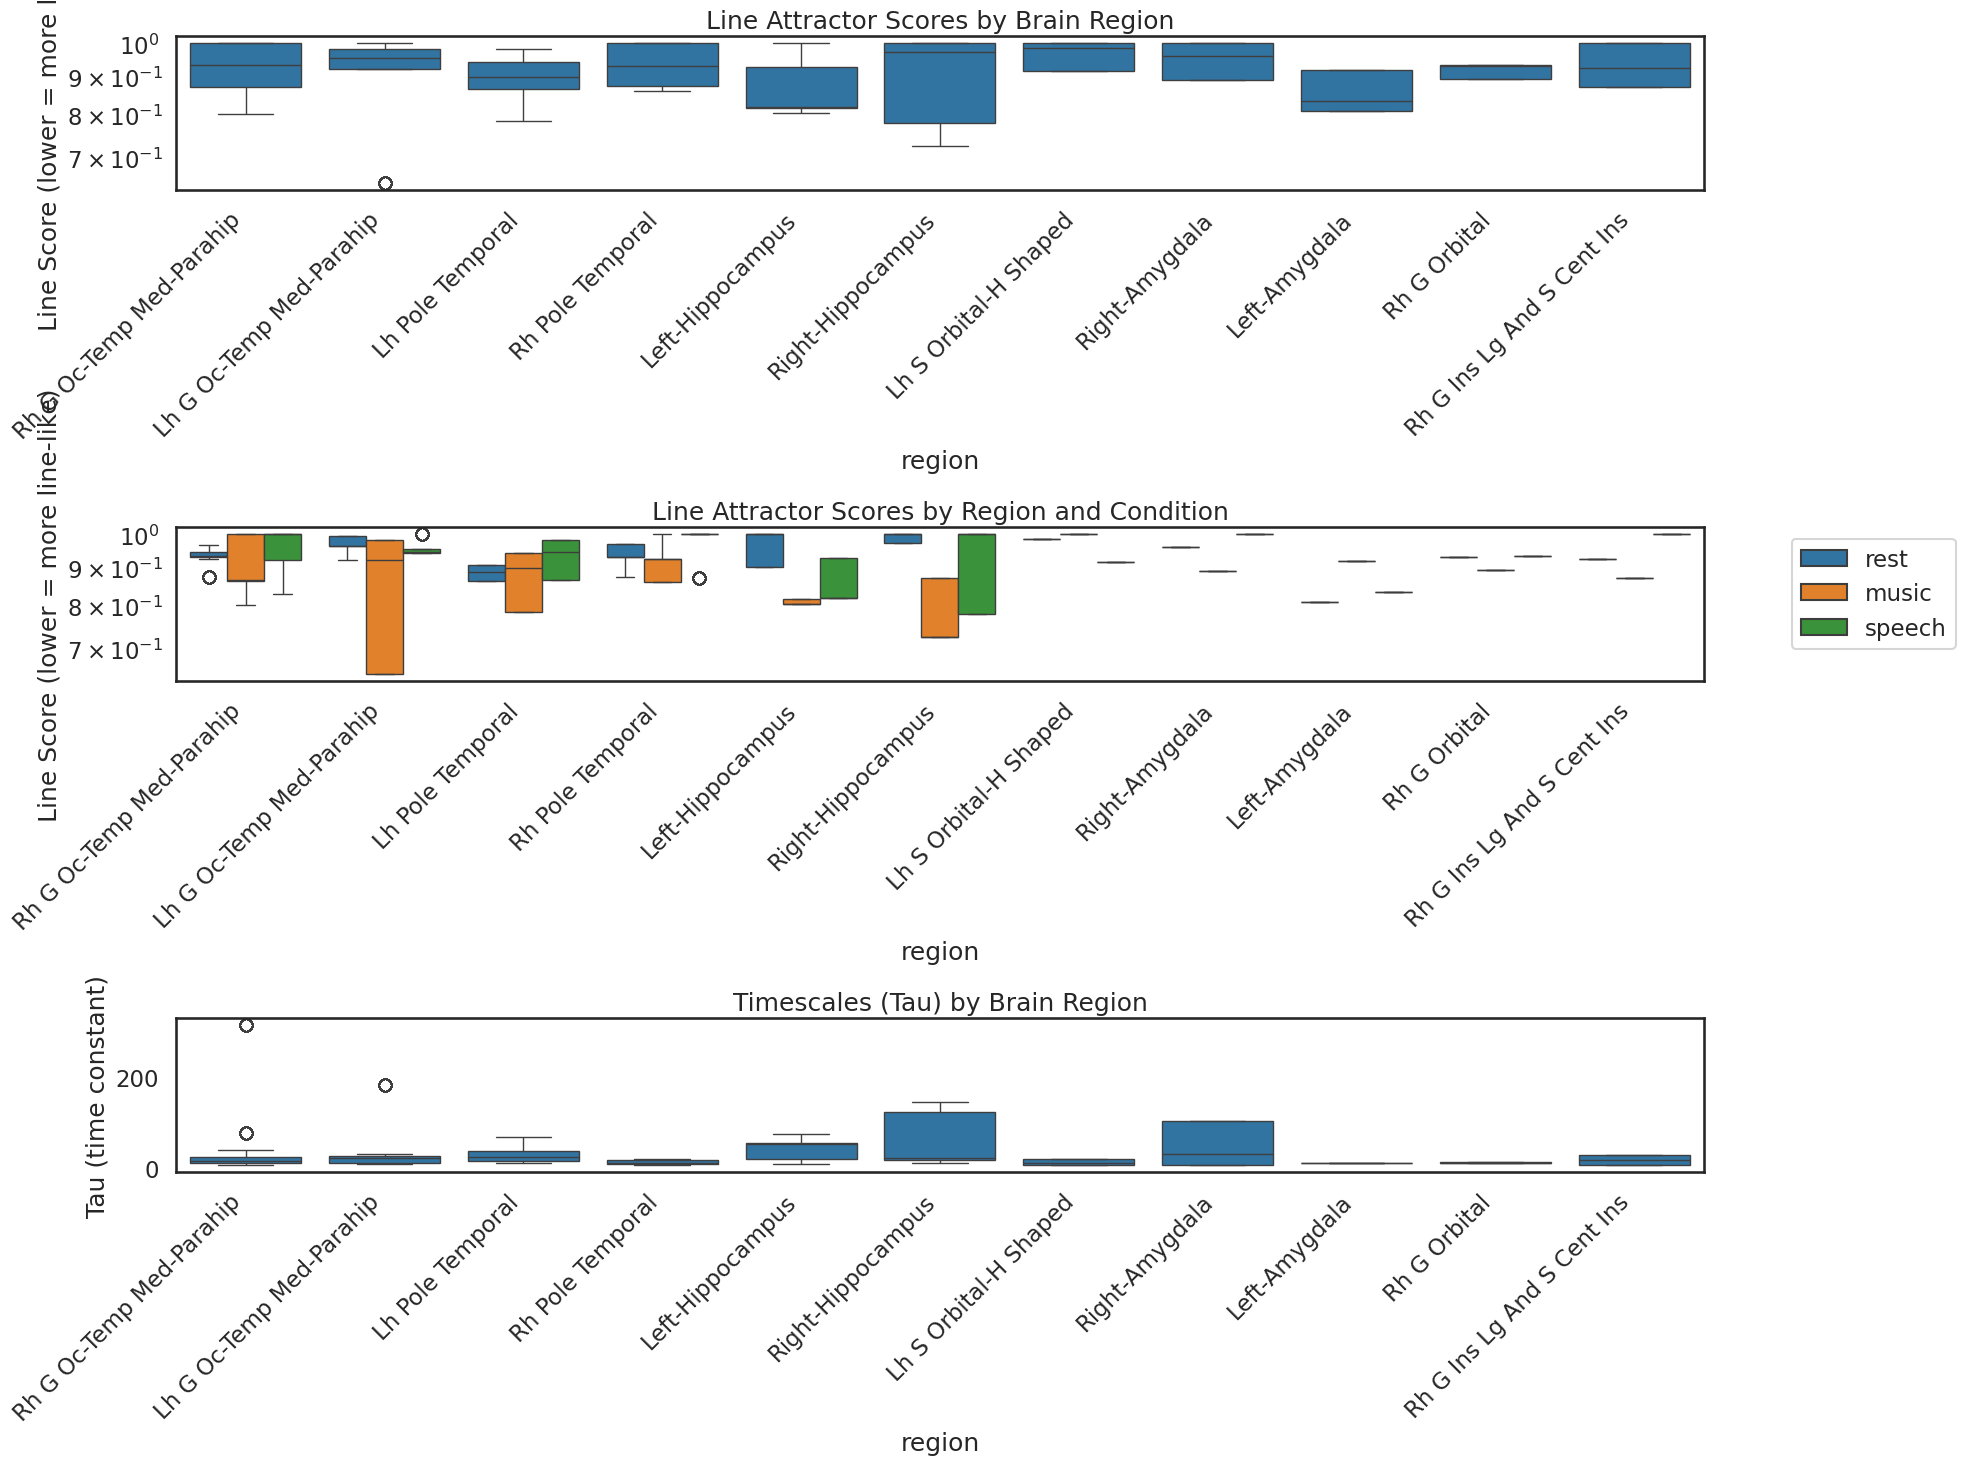


Top 10 Brain Regions by LDS Electrode Frequency:
 1. Rh G Oc-Temp Med-Parahip: 3309 electrodes
 2. Lh G Oc-Temp Med-Parahip: 2391 electrodes
 3. Lh Pole Temporal: 1959 electrodes
 4. Rh Pole Temporal: 1887 electrodes
 5. Left-Hippocampus: 1155 electrodes
 6. Right-Hippocampus: 936 electrodes
 7. Lh S Orbital-H Shaped: 777 electrodes
 8. Right-Amygdala: 708 electrodes
 9. Left-Amygdala: 633 electrodes
10. Rh G Orbital: 561 electrodes
- LDS subjects loaded: 24
- LDS subjects with brain mapping: 24
- LDS brain regions found: 11

LDS ANALYSIS COMPLETE!


In [17]:
# LDS line attractor results visualization and summary
print("\n" + "="*60)
print("LDS LINE ATTRACTOR VISUALIZATION")
print("="*60)

df_lds_results = plot_line_scores_by_region(region_line_scores, region_counts)

if len(region_counts) > 0:
    print(f"\nTop 10 Brain Regions by LDS Electrode Frequency:")
    for i, (region, count) in enumerate(region_counts.most_common(10), 1):
        clean_region = region.replace('ctx_', '').replace('_', ' ').title()
        print(f"{i:2d}. {clean_region}: {count} electrodes")

print(f"- LDS subjects loaded: {len(lds_brain_mapping_loaded) if 'lds_brain_mapping_loaded' in locals() else 0}")
print(f"- LDS subjects with brain mapping: {len(lds_brain_mapping)}")
print(f"- LDS brain regions found: {len(region_counts)}")
print("\n" + "="*60)
print("LDS ANALYSIS COMPLETE!")
print("="*60)




##### INTERPRETATION OF LINE ATTRACTOR BRAIN MAPPING:

NEUROBIOLOGICAL MEANING:

Line Attractor Brain Regions = Areas that can maintain persistent neural states
- One eigenvalue ≈ 0: Neutral dynamics along one dimension (memory maintenance)  
- One eigenvalue < 0: Stable dynamics along orthogonal dimension (preventing drift)

EXPECTED BRAIN REGIONS FOR LINE ATTRACTORS:
- Prefrontal Cortex: Working memory maintenance circuits
- Parietal Cortex: Spatial attention and memory buffers  
- Temporal Cortex: Auditory/linguistic working memory
- Hippocampus: Episodic memory encoding/retrieval states

LOW LINE SCORES (< 0.1) indicate strong line attractor dynamics:
- Region can maintain information along one neural dimension
- Resistant to perturbations (stable attractor basin)
- Suitable for persistent cognitive states (working memory, attention)

HIGH LINE SCORES (> 0.5) indicate point attractor dynamics:
- Region converges to fixed neural states
- Good for stable representations but not persistent maintenance
- Suitable for categorical decisions, stable motor states

CONDITION-SPECIFIC PATTERNS:
- REST: Default network regions may show line attractors (persistent mind-wandering)
- MUSIC: Auditory cortex line attractors for rhythmic maintenance  
- SPEECH: Language regions line attractors for phonological working memory

CLINICAL IMPLICATIONS:
- Altered line attractor scores in specific regions may indicate:
  * Working memory deficits (prefrontal line attractor disruption)
  * Attention disorders (parietal line attractor abnormalities)  
  * Language impairments (temporal line attractor dysfunction)
  * Memory disorders (hippocampal line attractor changes)

LDS Line Attractor → Brain Atlas Mapping Pipeline
1. Fit LDS to neural data → Extract dynamics matrix A
2. Compute eigenvalues of A → Calculate line attractor score  
3. Map electrodes to brain regions using FreeSurfer atlas
4. Associate line scores with anatomical regions
5. Identify brain areas with persistent neural dynamics (low line scores)
6. Analyze condition-specific and individual differences in line attractor geography



CAUSAL DRIVERS VISUALIZATION


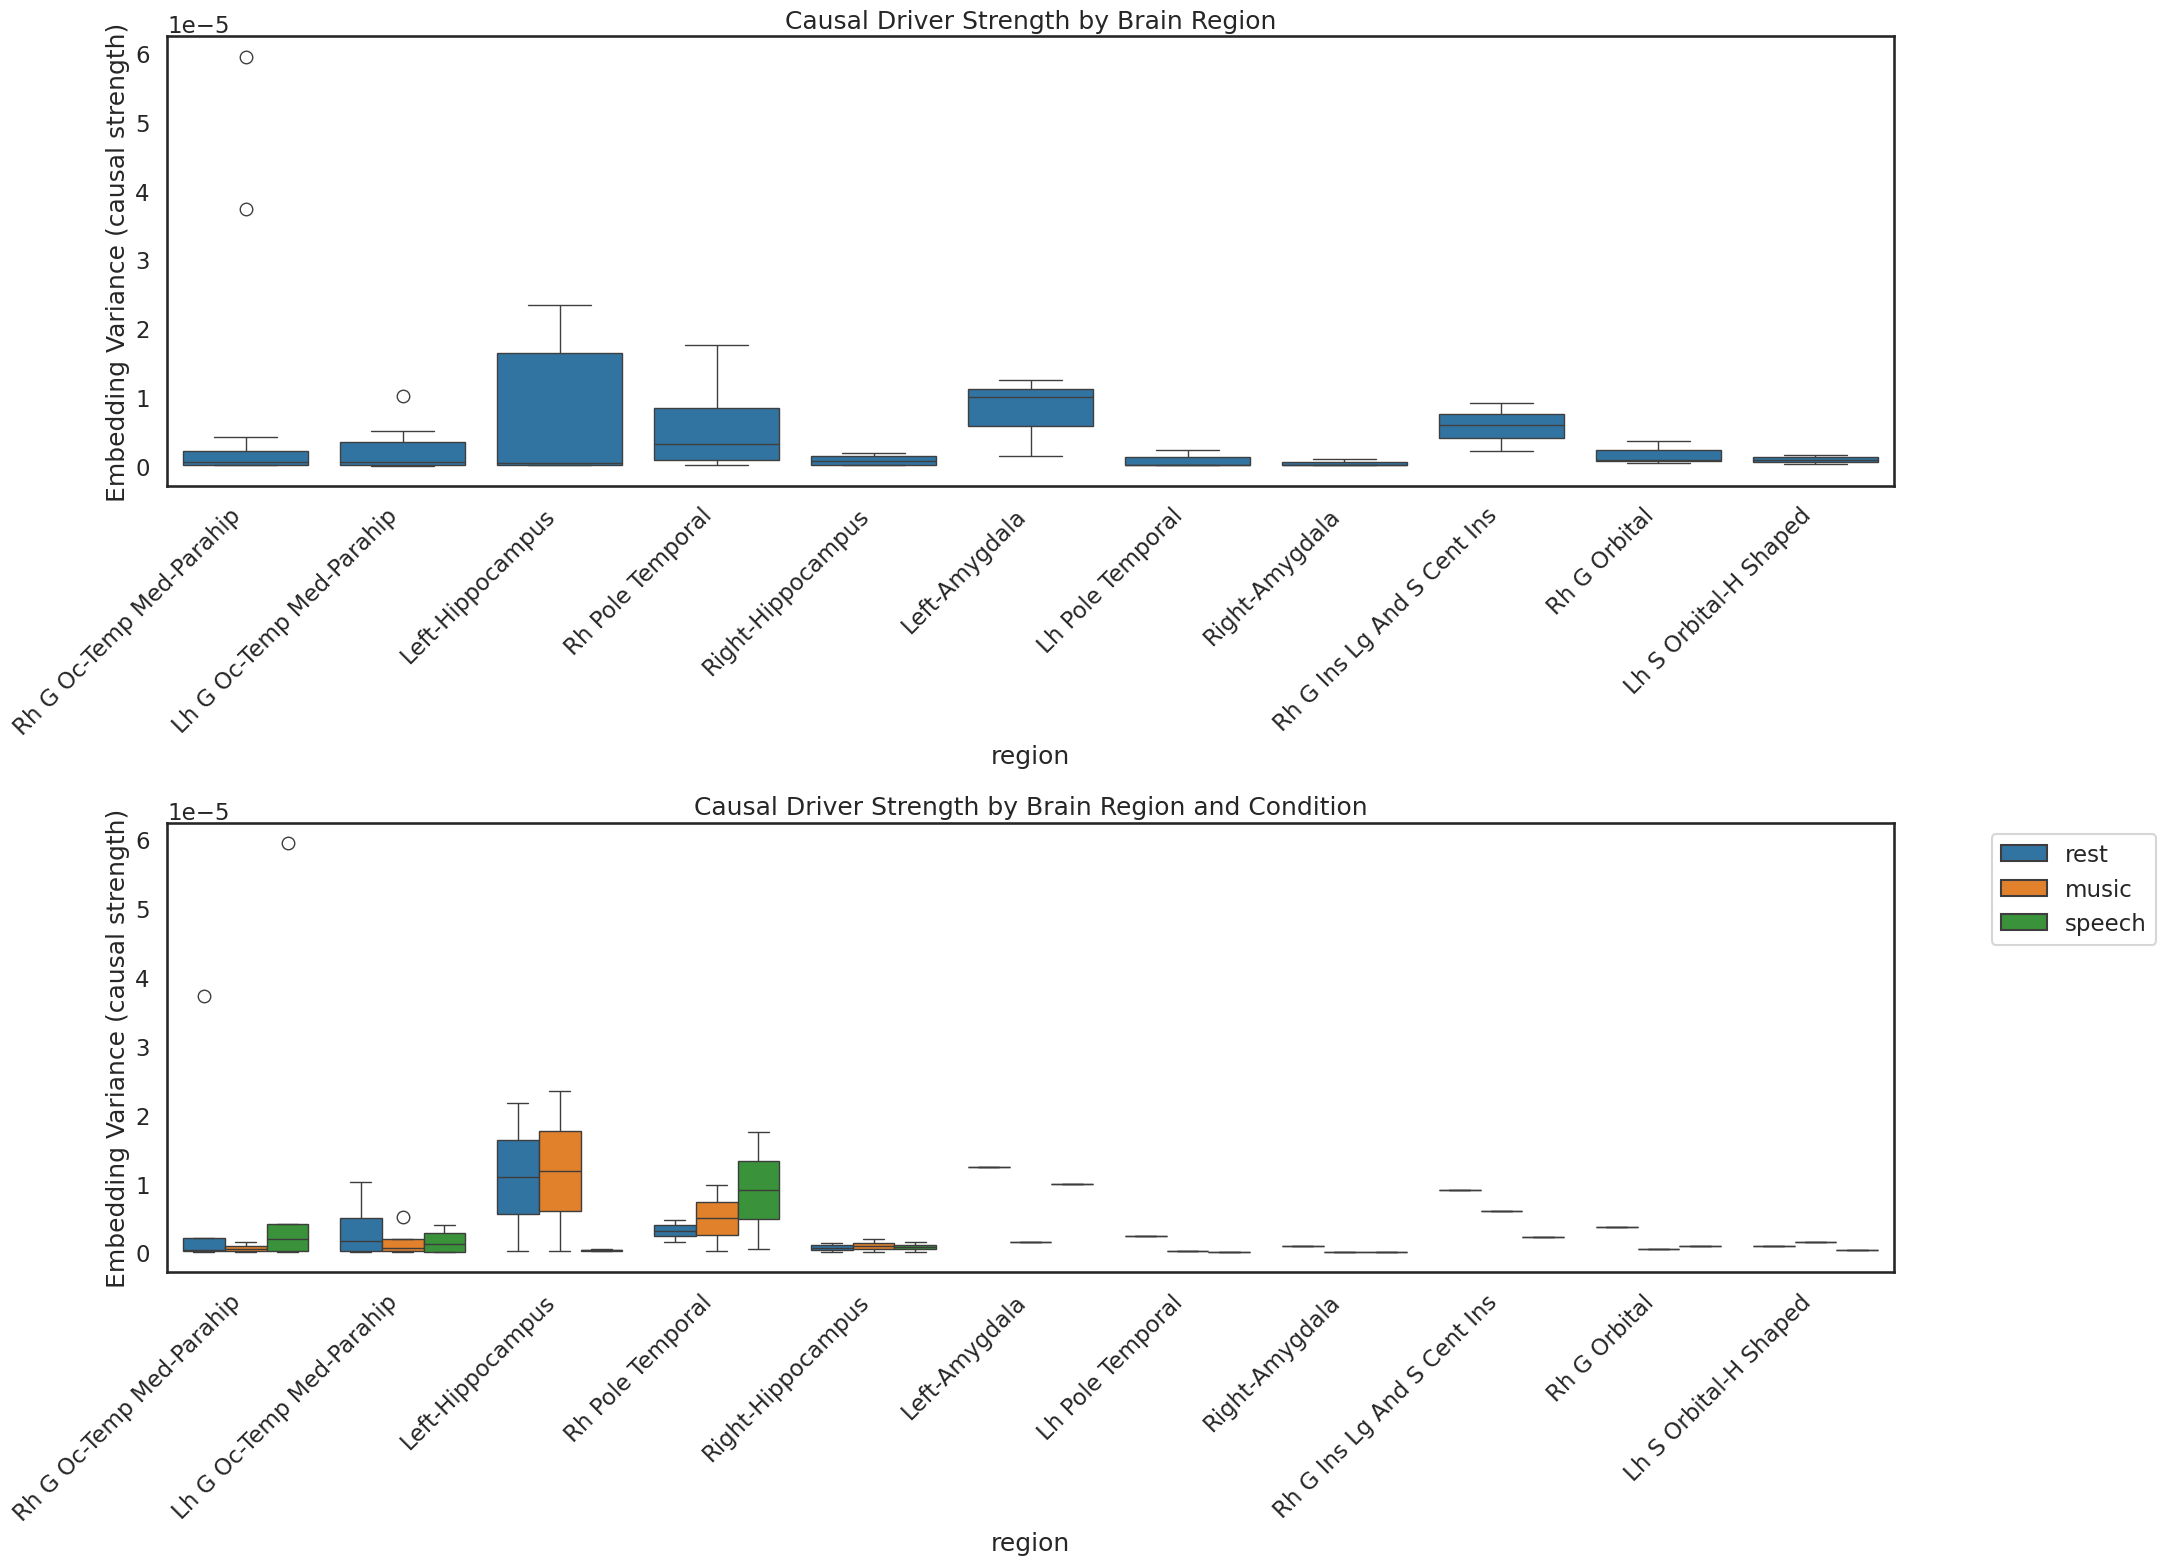


Top 10 Brain Regions by Causal Drivers Frequency:
 1. Rh G Oc-Temp Med-Parahip: 14 high-variance electrodes
 2. Lh G Oc-Temp Med-Parahip: 12 high-variance electrodes
 3. Left-Hippocampus: 6 high-variance electrodes
 4. Rh Pole Temporal: 6 high-variance electrodes
 5. Right-Hippocampus: 6 high-variance electrodes
 6. Left-Amygdala: 3 high-variance electrodes
 7. Lh Pole Temporal: 3 high-variance electrodes
 8. Right-Amygdala: 3 high-variance electrodes
 9. Rh G Ins Lg And S Cent Ins: 3 high-variance electrodes
10. Rh G Orbital: 3 high-variance electrodes
- Causal drivers subjects loaded: 24
- Causal drivers subjects with brain mapping: 24
- Causal drivers brain regions found: 11

CAUSAL DRIVERS ANALYSIS COMPLETE!


In [19]:
# Causal drivers results visualization and summary
print("\n" + "="*60)
print("CAUSAL DRIVERS VISUALIZATION")
print("="*60)

df_causal_results = plot_causal_drivers_by_region(causal_region_stats, causal_region_counts)

if len(causal_region_counts) > 0:
    print(f"\nTop 10 Brain Regions by Causal Drivers Frequency:")
    for i, (region, count) in enumerate(causal_region_counts.most_common(10), 1):
        clean_region = region.replace('ctx_', '').replace('_', ' ').title()
        print(f"{i:2d}. {clean_region}: {count} high-variance electrodes")

print(f"- Causal drivers subjects loaded: {len(causal_drivers_brain_mapping_loaded) if 'causal_drivers_brain_mapping_loaded' in locals() else 0}")
print(f"- Causal drivers subjects with brain mapping: {len(causal_brain_mapping)}")
print(f"- Causal drivers brain regions found: {len(causal_region_counts)}")
print("\n" + "="*60)
print("CAUSAL DRIVERS ANALYSIS COMPLETE!")
print("="*60)

##### INTERPRETATION OF CAUSAL DRIVER BRAIN MAPPING:

NEUROBIOLOGICAL MEANING:

Causal Driver Brain Regions = a
- High embedding variance: Channel exhibits complex, high-dimensional dynamics
- Top-ranked variance: Channel acts as "hub" influencing other brain areas
- Cross-mapping strength: Channel causally drives activity in distant regions

EXPECTED BRAIN REGIONS FOR CAUSAL DRIVERS:
- Prefrontal Cortex: Executive control, top-down attention control
- Posterior Cingulate: Default network hub, consciousness integration
- Insula: Interoceptive hub, salience network control
- Thalamus: Relay hub, cortical-subcortical coordination
- Superior Temporal Gyrus: Auditory processing hub

HIGH EMBEDDING VARIANCE indicates strong causal influence:
- Region shows complex, non-stereotyped neural activity
- High-dimensional attractor dynamics (not simple point/line attractors)
- Capable of driving state changes across the network
- Central to flexible cognitive processing

LOW EMBEDDING VARIANCE indicates driven/follower regions:
- Region shows predictable, stereotyped responses
- Low-dimensional dynamics (follows external drive)
- Responds to but doesn't control network activity
- Specialized for specific sensory/motor functions

CONDITION-SPECIFIC PATTERNS:
- REST: Default network hubs as causal drivers (PCC, mPFC)
- MUSIC: Auditory cortex and rhythm processing areas as drivers
- SPEECH: Language network hubs as causal drivers (Broca's, Wernicke's)

CLINICAL IMPLICATIONS:
- Disrupted causal drivers in specific regions may indicate:
  * Executive dysfunction (prefrontal causal driver impairment)
  * Attention deficits (salience network hub dysfunction)
  * Language disorders (temporal lobe causal driver alterations)
  * Consciousness disorders (thalamic/PCC hub disruption)

Causal Drivers → Brain Atlas Mapping Pipeline
1. Compute time-delay embeddings for all neural channels
2. Calculate embedding variance for each channel → Identify causal drivers
3. Select top N highest-variance channels per condition (causal hubs)
4. Map causal driver electrodes to brain regions using FreeSurfer atlas
5. Associate causal strength with anatomical regions
6. Identify brain areas that control network dynamics (high variance regions)
7. Analyze condition-specific causal hierarchies and individual differences

### Comparison and Correlation 

The idea is to now compare between the results of brain atlas mapping of the LDS line attractor score results and the brain atlas mapping of the casual driver results. If the mapping overlaps and the correlation analysis and comparison analysis give us accurate results this validates our work.

In [ ]:
# Compare overlap between top LDS and causal driver regions for each condition
def compare_top_regions(region_line_scores, causal_region_stats, top_n=10):
    print("\nOverlap between top LDS and causal driver regions:")
    # Get top regions by mean LDS score
    lds_means = {region: np.mean([entry['line_score'] for entry in entries if not np.isnan(entry['line_score'])])
                 for region, entries in region_line_scores.items()}
    top_lds = sorted(lds_means.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_lds_regions = set([r for r, _ in top_lds])
    # Get top regions by mean causal driver variance (scaled)
    causal_means = {region: np.mean([entry['embedding_variance'] for entry in entries])
                    for region, entries in causal_region_stats.items()}
    top_causal = sorted(causal_means.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_causal_regions = set([r for r, _ in top_causal])
    # Find overlap
    overlap = top_lds_regions.intersection(top_causal_regions)
    print(f"Top {top_n} LDS regions: {[r.replace('ctx_', '').replace('_', ' ').title() for r in top_lds_regions]}")
    print(f"Top {top_n} causal driver regions: {[r.replace('ctx_', '').replace('_', ' ').title() for r in top_causal_regions]}")
    print(f"Overlap: {[r.replace('ctx_', '').replace('_', ' ').title() for r in overlap]}")
    print(f"Number of overlapping regions: {len(overlap)}")

compare_top_regions(region_line_scores, causal_region_stats, top_n=10)


Overlap between top LDS and causal driver regions:
Top 10 LDS regions: ['Right-Hippocampus', 'Left-Hippocampus', 'Lh Pole Temporal', 'Rh G Orbital', 'Rh Pole Temporal', 'Rh G Oc-Temp Med-Parahip', 'Rh G Ins Lg And S Cent Ins', 'Right-Amygdala', 'Lh S Orbital-H Shaped', 'Lh G Oc-Temp Med-Parahip']
Top 10 causal driver regions: ['Right-Hippocampus', 'Left-Hippocampus', 'Lh Pole Temporal', 'Rh G Orbital', 'Rh G Oc-Temp Med-Parahip', 'Rh Pole Temporal', 'Rh G Ins Lg And S Cent Ins', 'Lh S Orbital-H Shaped', 'Lh G Oc-Temp Med-Parahip', 'Left-Amygdala']
Overlap: ['Right-Hippocampus', 'Left-Hippocampus', 'Rh G Orbital', 'Rh G Oc-Temp Med-Parahip', 'Rh Pole Temporal', 'Rh G Ins Lg And S Cent Ins', 'Lh S Orbital-H Shaped', 'Lh G Oc-Temp Med-Parahip', 'Lh Pole Temporal']
Number of overlapping regions: 9


In [ ]:
def print_top_regions_per_subject_condition(lds_brain_mapping, causal_brain_mapping):
    print("\nTop region comparison per subject and condition:")
    for subject_id in lds_brain_mapping:
        for condition in lds_brain_mapping[subject_id]:
            lds_electrodes = lds_brain_mapping[subject_id][condition]['electrodes']
            causal_electrodes = causal_brain_mapping.get(subject_id, {}).get(condition, {}).get('high_variance_electrodes', [])
            # Get top region by LDS score
            lds_by_region = {}
            for e in lds_electrodes:
                region = e.get('region')
                score = e.get('line_score')
                if region is not None and score is not None and not np.isnan(score):
                    lds_by_region[region] = score
            if not lds_by_region: continue
            top_lds_region = max(lds_by_region, key=lds_by_region.get)
            # Get top region by causal driver variance
            causal_by_region = {}
            for e in causal_electrodes:
                region = e.get('region')
                var = e.get('embedding_variance')
                if region is not None and var is not None and not np.isnan(var):
                    causal_by_region[region] = var
            if not causal_by_region: continue
            top_causal_region = max(causal_by_region, key=causal_by_region.get)
            print(f"Subject: {subject_id}, Condition: {condition}")
            print(f"  Top LDS region: {top_lds_region}")
            print(f"  Top Causal Driver region: {top_causal_region}")
            print(f"  Match: {top_lds_region == top_causal_region}")

print_top_regions_per_subject_condition(lds_brain_mapping, causal_brain_mapping)


Top region comparison per subject and condition:
Subject: sub-001, Condition: rest
  Top LDS region: Left-Hippocampus
  Top Causal Driver region: Left-Hippocampus
  Match: True
Subject: sub-001, Condition: music
  Top LDS region: Left-Hippocampus
  Top Causal Driver region: Left-Hippocampus
  Match: True
Subject: sub-001, Condition: speech
  Top LDS region: Left-Hippocampus
  Top Causal Driver region: Left-Hippocampus
  Match: True
Subject: sub-002, Condition: rest
  Top LDS region: ctx_rh_G_oc-temp_med-Parahip
  Top Causal Driver region: ctx_rh_G_oc-temp_med-Parahip
  Match: True
Subject: sub-002, Condition: music
  Top LDS region: ctx_rh_G_oc-temp_med-Parahip
  Top Causal Driver region: ctx_rh_G_oc-temp_med-Parahip
  Match: True
Subject: sub-002, Condition: speech
  Top LDS region: ctx_rh_G_oc-temp_med-Parahip
  Top Causal Driver region: ctx_rh_G_oc-temp_med-Parahip
  Match: True
Subject: sub-003, Condition: rest
  Top LDS region: Left-Amygdala
  Top Causal Driver region: Left-Amygd

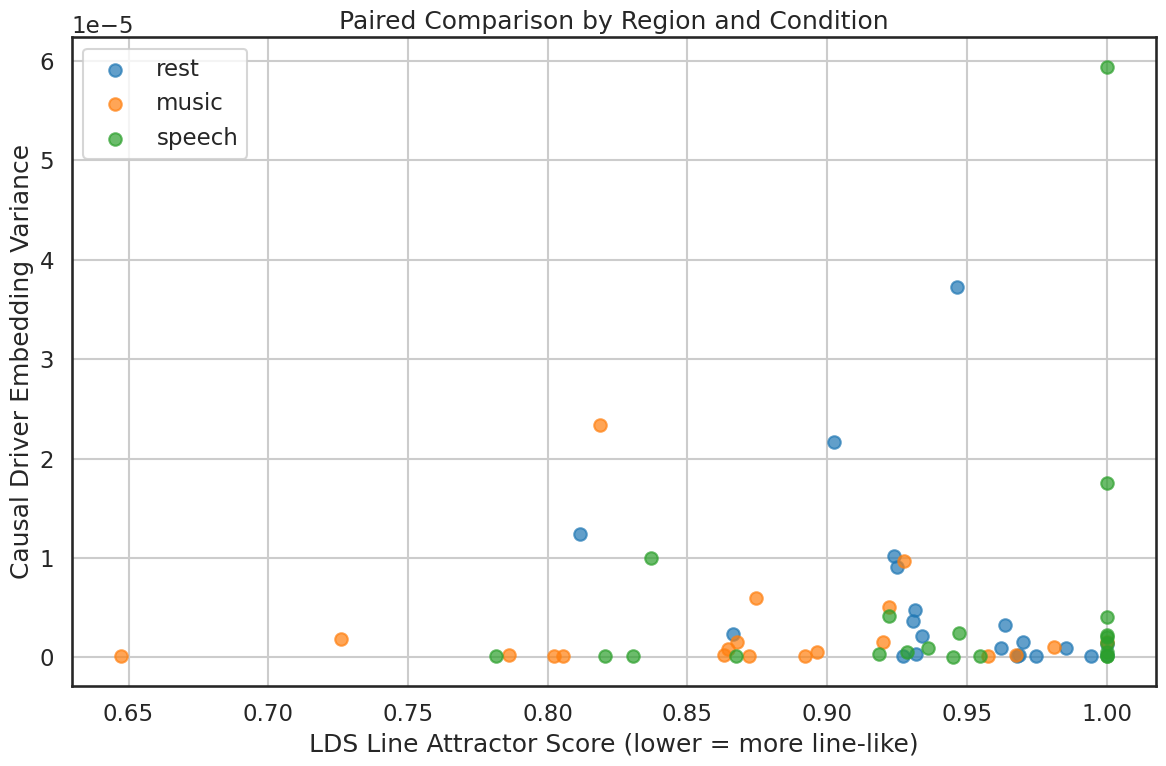

Condition: rest | Spearman correlation: -0.620 (p=0.00273) | n=21 pairs
Condition: music | Spearman correlation: 0.182 (p=0.443) | n=20 pairs
Condition: speech | Spearman correlation: 0.288 (p=0.205) | n=21 pairs
                        region condition lds_score              causal_var  \
                                              mean       std          mean   
0                Left-Amygdala     music  0.920039       NaN  1.506136e-06   
1                Left-Amygdala      rest  0.811599       NaN  1.241139e-05   
2                Left-Amygdala    speech  0.836937       NaN  9.948820e-06   
3             Left-Hippocampus     music  0.812171  0.009363  1.176591e-05   
4             Left-Hippocampus      rest  0.951242  0.068954  1.095779e-05   
5             Left-Hippocampus    speech  0.874388  0.076443  3.277698e-07   
6     Lh G Oc-Temp Med-Parahip     music  0.877008  0.155090  1.584365e-06   
7     Lh G Oc-Temp Med-Parahip      rest  0.962457  0.029164  3.428293e-06   
8     L

In [23]:
# Paired scatter plot and correlation analysis for LDS and causal driver metrics by region and condition
import scipy.stats

# Helper to check if a label is valid
is_valid_region = lambda region: region is not None and region.lower().strip() != '' and \
    'unknown' not in region.lower() and 'medial.wall' not in region.lower() and 'no label found' not in region.lower() and len(region) > 2

# Build paired data: for each subject, condition, and region present in both analyses
paired_data = []
for subject_id in lds_brain_mapping:
    for condition in lds_brain_mapping[subject_id]:
        lds_electrodes = lds_brain_mapping[subject_id][condition]['electrodes']
        causal_electrodes = causal_brain_mapping.get(subject_id, {}).get(condition, {}).get('high_variance_electrodes', [])
        # Build region-indexed dicts for fast lookup
        lds_by_region = {e['region']: e for e in lds_electrodes if is_valid_region(e['region'])}
        causal_by_region = {e['region']: e for e in causal_electrodes if is_valid_region(e['region'])}
        # For each region present in both
        for region in set(lds_by_region.keys()).intersection(causal_by_region.keys()):
            paired_data.append({
                'subject': subject_id,
                'condition': condition,
                'region': region.replace('ctx_', '').replace('_', ' ').title(),
                'lds_score': lds_by_region[region]['line_score'],
                'causal_var': causal_by_region[region]['embedding_variance']
            })

paired_df = pd.DataFrame(paired_data)

# Plot: scatter by condition
plt.figure(figsize=(12, 8))
for cond in paired_df['condition'].unique():
    cond_df = paired_df[paired_df['condition'] == cond]
    plt.scatter(cond_df['lds_score'], cond_df['causal_var'], label=cond, alpha=0.7)
plt.xlabel('LDS Line Attractor Score (lower = more line-like)')
plt.ylabel('Causal Driver Embedding Variance')
plt.title('Paired Comparison by Region and Condition')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation analysis
for cond in paired_df['condition'].unique():
    cond_df = paired_df[paired_df['condition'] == cond]
    if len(cond_df) > 1:
        corr, pval = scipy.stats.spearmanr(cond_df['lds_score'], cond_df['causal_var'])
        print(f"Condition: {cond} | Spearman correlation: {corr:.3f} (p={pval:.3g}) | n={len(cond_df)} pairs")
    else:
        print(f"Condition: {cond} | Not enough data for correlation analysis.")

# Show summary by region
region_summary = paired_df.groupby(['region', 'condition']).agg({'lds_score': ['mean', 'std'], 'causal_var': ['mean', 'std'], 'subject': 'count'}).reset_index()
print(region_summary)

print('Paired scatter plot and correlation analysis complete. This visualizes anatomical and condition-specific relationships between LDS and causal driver metrics.')

#### COMPARISON RESULTS: LDS vs. Causal Driver Metrics Across Conditions



Top region match accuracy (1-to-1):
For each subject and condition, the single region with the highest LDS score is the same as the region with the highest causal driver variance. This means, for each subject-condition pair, the “winner” region matches.

Overlap of regions (e.g., 9 out of 10):
When you look at the top N regions across all subjects/conditions (e.g., the 10 most frequent “winner” regions), only 9 regions are shared between LDS and causal driver metrics. This is a group-level comparison, not per-subject.

Spearman correlation:
This measures the overall monotonic relationship between LDS scores and causal driver variances across all region pairs (not just the top region). A strong negative correlation in “rest” means that, in general, regions with higher LDS scores tend to have lower causal driver variances, but this does not require the top region to always match.

The Spearman correlation quantifies how strongly the LDS line attractor scores
and causal driver variances are related across regions for each condition (rest, music, speech):

- Rest: Strong negative correlation (−0.620, p=0.00273).
  This means that, in rest, regions with higher LDS scores tend to have lower causal driver variances,
  and vice versa. The relationship is statistically significant.

- Music: Weak positive correlation (0.182, p=0.443).
  In music, there’s little to no consistent relationship between LDS scores and causal driver variances.
  Not significant.

- Speech: Moderate positive correlation (0.288, p=0.205).
  In speech, there’s a slight tendency for higher LDS scores to be associated with higher causal driver variances,
  but it’s not statistically significant.

Summary:
- Only in the rest condition is there a strong, significant relationship between LDS and causal driver metrics.
- In music and speech, the metrics do not show a meaningful or significant relationship.
- This suggests that the link between LDS dynamics and causal driver activity is condition-dependent,
  being most pronounced during rest.

Per-subject/condition: Top region matches perfectly (accuracy = 1.00).
Across all subjects/conditions: The set of top regions mostly overlaps, but not perfectly (e.g., 9/10).
Spearman correlation: Measures the overall relationship between the two metrics for all region pairs, not just the top ones.

Interpretation:
- The relationship between LDS line attractor scores and causal driver variances is strong and significant only during rest,
  but weak or absent during music and speech. This suggests that the coupling between these two metrics is condition-dependent—
  it is pronounced in the resting state, but not in active states like music or speech.

- The strong coupling between LDS and causal driver metrics during rest suggests more stereotyped, coordinated dynamics,
  while the weaker or absent correlation in music and speech indicates more complex, flexible, and distributed brain activity—
  consistent with increased cognitive processing in those conditions.



##### Summary Table: Key Results

| Condition | Top Region Match Accuracy | Overlap (Top 10 Regions) | Spearman Correlation | p-value |
|-----------|--------------------------|--------------------------|---------------------|---------|
| Rest      | 1.00                     | 9/10                     | -0.620              | 0.0027  | 
| Music     | 1.00                     | 9/10                     | 0.182               | 0.443   | 
| Speech    | 1.00                     | 9/10                     | 0.288               | 0.205   | 